In [20]:
!nvidia-smi

Fri Apr  7 17:30:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.05    Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 44%   50C    P8    27W / 350W |   2544MiB / 24576MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau

# metric
from sklearn.metrics import fbeta_score

import wandb

# config

In [22]:
BASE_DIR = "/working/"
INPUT_DIR = os.path.join(BASE_DIR, "input")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")
SURFACE_NUM = 5

OUTPUT_DIR = os.path.join(BASE_DIR, "output")

CFG = {
    "DEBUG" : False,
    # exp setting
    "EXP_CATEGORY" : "makebase",
    "EXP_NAME" : "base000",
    "folds" : ["0"],

    # model
    "model_name" : "tf_efficientnet_b0",
    "inp_channels" : SURFACE_NUM + 1,
    "out_channels" : 1,
    "pretrained" : True,
    "out_indices" : [0,1,2,3,4],
 
    # data   
    "img_size": [256, 256],
    "batch_size": 16,
    "INPUT_DIR": INPUT_DIR,
    "TRAIN_DIR": TRAIN_DIR,
    "TEST_DIR": TEST_DIR,
    "OUTPUT_DIR": OUTPUT_DIR,
    "surface_num": SURFACE_NUM,
    # "TRAIN_IDX_LIST": ["1", "2"],
    "TRAIN_IDX_LIST" : ["1"],
    "VALID_IDX_LIST": ["3"],
    "TEST_IDX_LIST": ["a", "b"],

    # learning
    "n_epoch" : 30,
    "lr" : 1e-3,
    "T_max" : 10,
    "min_lr" : 1e-8,
    "weight_decay" : 1e-6,

    # etc
    "print_freq" : 1000,
    "random_seed" : 21,
    "num_workers": 2,
}

if CFG["DEBUG"]:
    CFG["n_epoch"] = 1
    CFG["EXP_NAME"] = "DEBUG"

In [23]:
# if not CFG["DEBUG"]:
#     exp_path = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"])
#     print(exp_path)
#     os.makedirs(exp_path)

In [24]:
# if not CFG["DEBUG"]:
#     os.environ["WANDB_SILENT"] = "true"
#     WANDB_CONFIG = {'competition': 'VCID', '_wandb_kernel': 'taro'}

#     wandb.init(project=WANDB_CONFIG["competition"], config=CFG, group=CFG["EXP_CATEGORY"], name=CFG["EXP_NAME"])

# utils

In [25]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [26]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [27]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

# model

In [28]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        channel_nums = [320, 112, 40, 24, 16, 8]
        self.UpConv_0 = UpConv(channel_nums[0], channel_nums[1])
        self.UpConv_1 = UpConv(channel_nums[1]*2, channel_nums[2])
        self.UpConv_2 = UpConv(channel_nums[2]*2, channel_nums[3])
        self.UpConv_3 = UpConv(channel_nums[3]*2, channel_nums[4])
        self.UpConv_4 = UpConv(channel_nums[4]*2, channel_nums[5])
    
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
        emb = self.UpConv_3(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

        emb_cat = self.UpConv_4(emb_cat)
        
        return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            # nn.Conv2d(32, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
            nn.Conv2d(8, CFG["out_channels"], kernel_size=1, stride=1, padding="same"),
            nn.Sigmoid()
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        emb = self.decoder(skip_connection_list)
        output = self.head(emb)
        return output

# Dataset

In [29]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ToFloat(max_value=255),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.ToFloat(max_value=255),
    ToTensorV2(),
])


In [30]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, mode="train", transform=None):
        # get config
        self.mode = mode
        if self.mode=="train":
            self.DATADIR = CFG["TRAIN_DIR"]
            self.data_idx_list = CFG["TRAIN_IDX_LIST"]
        elif self.mode=="valid":
            self.DATADIR = CFG["TRAIN_DIR"]
            self.data_idx_list = CFG["VALID_IDX_LIST"]
        elif self.mode == "test":
            self.DATADIR = CFG["TEST_DIR"]
            self.data_idx_list = CFG["TEST_IDX_LIST"]
        self.surface_num = CFG["surface_num"]
        self.img_size = CFG["img_size"]
        self.transform = transform
        
        # get imgs
        print("initializing dataset...")
        self.imgs = []
        for idx in self.data_idx_list:
            img_path = os.path.join(self.DATADIR, idx, "mask.png")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            self.imgs.append(img)
        
        # check imgs
        for img in self.imgs:
            assert img is not None, "img is None. data path is wrong"
        # get and split surface
        self.surface_vols = self.read_surfacevols()
        for surface_vol in self.surface_vols:
            assert surface_vol is not None, "surface_vol is None. data path is wrong"
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for idx in self.data_idx_list:
                label_path = os.path.join(self.DATADIR, idx, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        print("initializing dataset done.")

    def read_surfacevols(self):
        surface_vols = []
        print("reading surface volume...")
        for img_idx in self.data_idx_list:
            surface_vol_ = None
            for i in range(self.surface_num):
                print("\r", f"reading idx : {i+1}/{self.surface_num}", end="")
                surface_path = os.path.join(self.DATADIR, img_idx, "surface_volume", f"{i:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            print(f"  => read surface volume done. [{img_idx}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        img_grid = img[grid_idx[0]*self.img_size[0]:(grid_idx[0]+1)*self.img_size[0],
                        grid_idx[1]*self.img_size[1]:(grid_idx[1]+1)*self.img_size[1]]
        return img_grid 

    def get_all_grid(self):
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = img.shape[0] // self.img_size[0]
            self.y_grid_size = img.shape[1] // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        img = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        img = self.get_grid_img(img, grid_idx)
        surface_vol = self.get_grid_img(surface_vol, grid_idx)
        assert surface_vol.shape[0]==img.shape[0] and surface_vol.shape[1]==img.shape[1] , "surface_vol_list shape is not same as img shape"
        
        # concat img & surface_vol in channel axix 
        img = np.concatenate([img, surface_vol], axis=2)
        # img = np.concatenate([img*255, surface_vol], axis=2)

        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            return img, label, grid_idx


In [31]:
# transforms = A.Compose([
#     A.HorizontalFlip(p=1.0),
#     # A.VerticalFlip(p=0.5),
#     # A.RandomRotate90(p=0.5),
#     A.ToFloat(max_value=255),
#     ToTensorV2(),
# ])

# print("dataset")
# dataset = VCID_Dataset(CFG, mode="train", transform=transforms)
# print("dataloader")
# dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)


# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, mode="train")
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


In [32]:
# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader):
#     img = imgs[0].permute(1, 2, 0)
#     label = labels[0].permute(1, 2, 0)
#     if batch_idx < imshow_batch:
#         pass
#     else:
#         print("batch_idx: ", batch_idx)
#         print(imgs.shape)
#         print(labels.shape)
#         print(img.shape)
#         print(label.shape)
#         plt.figure(figsize=(20, 20))
#         for idx in range(CFG["surface_num"]+1):
#             plt.subplot(1, CFG["surface_num"]+2, idx+1)
#             plt.imshow(img[:,:,idx])
#         plt.subplot(1, CFG["surface_num"]+2, 2+CFG["surface_num"])
#         plt.imshow(label)
#         plt.show()
#         break

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     label = labels[0].permute(1, 2, 0)
#     if batch_idx < imshow_batch:
#         pass
#     else:
#         print("batch_idx: ", batch_idx)
#         print(imgs.shape)
#         print(labels.shape)
#         print(img.shape)
#         print(label.shape)
#         plt.figure(figsize=(20, 20))
#         for idx in range(CFG["surface_num"]+1):
#             plt.subplot(1, CFG["surface_num"]+2, idx+1)
#             plt.imshow(img[:,:,idx])
#         plt.subplot(1, CFG["surface_num"]+2, 2+CFG["surface_num"])
#         plt.imshow(label)
#         plt.show()
#         break


In [33]:

# plt.figure(figsize=(20, 20))
# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     plt.subplot(1, imshow_batch+1, batch_idx+1)
#     plt.imshow(img[:,:,0])
#     if batch_idx >= imshow_batch:
#         break    
# plt.show()


# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten(), bins=np.arange(255))
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])

# train valid fn

In [34]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, _) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()     
        preds = model(images)
        
        # preds = torch.sigmoid(preds)
        loss = criterion(preds, targets)
        
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        # preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()
        preds = preds.detach().cpu().numpy().ravel().tolist()
        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('\t Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

In [35]:
def valid_fn(model, valid_loader, criterion):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []
    test_grid_idx = []
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, grid_idx) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()
        with torch.no_grad():
            preds = model(images)
            # preds = torch.sigmoid(preds)
            loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)
        # targets = targets.detach().cpu().numpy().ravel().tolist()
        # preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()
        # preds = preds.detach().cpu().numpy().ravel().tolist()
        targets = targets.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()
        
        # test_preds.append(preds)
        # test_targets.append(targets)
        test_preds.extend([preds[idx, :,:,:].transpose(1,2,0) for idx in range(preds.shape[0])])
        test_targets.extend([targets[idx, :,:,:].transpose(1,2,0) for idx in range(targets.shape[0])])
        test_grid_idx.extend([[x_idx, y_idx] for x_idx, y_idx in zip(grid_idx[0].tolist(), grid_idx[1].tolist())])
        # test_preds.extend(preds.flatten())
        # test_targets.extend(targets.flatten())
        # score = matthews_corrcoef(preds, targets)
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1):
            print('\t EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, targets
        gc.collect()
        torch.cuda.empty_cache()
    # test_preds = np.ndarray(test_preds)
    # test_targets = np.ndarray(test_targets)
    # print(test_preds.shape, test_targets.shape)
    return test_targets, test_preds, test_grid_idx, losses.avg

# training loop

In [36]:
def concat_grid_img(img_list, label_list, grid_idx_list):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], CFG["VALID_IDX_LIST"][0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        pred_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
                grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += img_list[img_idx]
        
        label_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
                grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += label_list[img_idx]
    return pred_img, label_img

In [37]:
def training_loop(CFG):
    # set model & learning fn
    model = SegModel(CFG)
    model = model.to(device)
    # if not CFG["DEBUG"]:
    #     wandb.watch(model)
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCELoss()
    optimizer = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
    for fold in CFG["folds"]:
        # separate train/valid data 
        train_dataset = VCID_Dataset(CFG, mode="train", transform=train_transforms)
        valid_dataset = VCID_Dataset(CFG, mode="valid", transform=valid_transforms)
        train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle = True,
                                    num_workers = CFG["num_workers"], pin_memory = True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                    num_workers = CFG["num_workers"], pin_memory = True)

        # training
        best_score = -np.inf
        start_time = time.time()
        for epoch in range(1, CFG["n_epoch"] + 1):
            print(f'\t === epoch: {epoch}: training ===')
            train_loss_avg = train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler)
            valid_targets, valid_preds, valid_grid_idx, valid_loss_avg = valid_fn(model, valid_loader, criterion)
            
            # target, predをconcatして元のサイズに戻す
            valid_preds_img, valid_targets_img  = concat_grid_img(valid_preds, valid_targets, valid_grid_idx)
            print("valid_preds shape = ", valid_preds_img.shape)
            print("valid_targets shape = ", valid_targets_img.shape)

            #  plot hisgram
            # plt.figure(dpi=100)
            # plt.subplot(1,2,1)
            # plt.hist(valid_preds_img.flatten(), bins=100)
            # plt.subplot(1,2,2)
            # plt.hist(valid_targets_img.flatten(), bins=100)
            # plt.show()

            valid_score, valid_threshold = calc_cv(valid_targets_img, valid_preds_img)

            valid_preds_binary = (valid_preds_img > valid_threshold).astype(np.uint8)
 
            plt.figure(dpi=100)
            plt.subplot(1,3,1)
            plt.imshow(valid_preds_img)
            plt.subplot(1,3,2)
            plt.imshow(valid_preds_binary)
            plt.subplot(1,3,3)
            plt.imshow(valid_targets_img)
            plt.show()

            elapsed = time.time() - start_time
            print(f'\t epoch:{epoch}, avg train loss:{train_loss_avg:.4f}, avg valid loss:{valid_loss_avg:.4f}, score:{valid_score:.4f}(th={valid_threshold}) ::: time:{elapsed:.2f}s')
            scheduler.step()
            # validationスコアがbestを更新したらモデルを保存する
            if valid_score > best_score:
                best_score = valid_score
                model_name = CFG["model_name"]
                model_path = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"], f'{model_name}_segmodel_fold{fold}.pth')
                torch.save(model.state_dict(), model_path) 
                print(f'\t Epoch {epoch} - Save Best Score: {best_score:.4f}. Model is saved.')

    # del train_loader, train_dataset, valid_loader, valid_dataset
    gc.collect()
    torch.cuda.empty_cache()

# main

initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [1]
split grid done.
initializing dataset done.
initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [3]
split grid done.
initializing dataset done.
	 === epoch: 1: training ===
	 Epoch: [1][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7174(0.7174) 
	 Epoch: [1][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.7026(0.6935) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4463(0.4463) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4957(0.5223) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807337487286492
th: 0.15, fbeta: 0.1380756111148303
th: 0.2, fbeta: 0.1381241479704798
th: 0.25, fbeta: 0.1385860349723707
th: 0.3, fbeta: 0.14136499343506545
th: 0.35, fbeta: 0.1536680286139597
th: 0.4, fbeta: 0.1494205546754431
th: 0.45, fbeta: 0.10268468372541606
th: 0.5, fbeta: 0.02615410572042645
th:

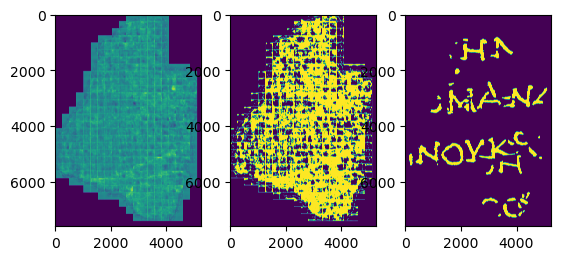

	 epoch:1, avg train loss:0.6935, avg valid loss:0.5223, score:0.1537(th=0.35) ::: time:12.69s
	 Epoch 1 - Save Best Score: 0.1537. Model is saved.
	 === epoch: 2: training ===
	 Epoch: [2][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6686(0.6686) 
	 Epoch: [2][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6510(0.6617) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 3s) Loss: 0.5147(0.5147) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5111(0.6082) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807337487286492
th: 0.15, fbeta: 0.13807365379801628
th: 0.2, fbeta: 0.13817002733515218
th: 0.25, fbeta: 0.13986427079935634
th: 0.3, fbeta: 0.154745049524428
th: 0.35, fbeta: 0.16083795618358077
th: 0.4, fbeta: 0.16056131092504822
th: 0.45, fbeta: 0.1549621015201949
th: 0.5, fbeta: 0.14208582496295283
th: 0.55, fbeta: 0.09985524355570018
th: 0.6, fbeta: 0.04635136828726839
th: 0.65, fbeta: 0.022062258951513564
th: 0.7, fbeta: 0.009160019817392884

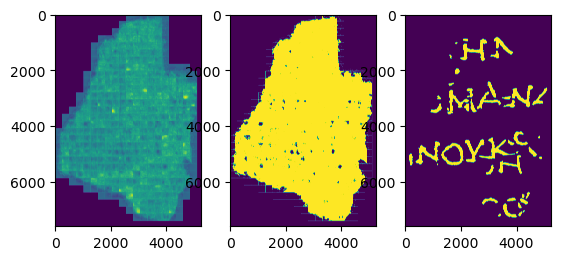

	 epoch:2, avg train loss:0.6617, avg valid loss:0.6082, score:0.1608(th=0.35) ::: time:25.21s
	 Epoch 2 - Save Best Score: 0.1608. Model is saved.
	 === epoch: 3: training ===
	 Epoch: [3][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.6409(0.6409) 
	 Epoch: [3][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6073(0.6380) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5358(0.5358) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5191(0.6989) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807337487286492
th: 0.15, fbeta: 0.13809807373437694
th: 0.2, fbeta: 0.13933457096652585
th: 0.25, fbeta: 0.14783138594061943
th: 0.3, fbeta: 0.16022475881121645
th: 0.35, fbeta: 0.16096463503935954
th: 0.4, fbeta: 0.15645981001399722
th: 0.45, fbeta: 0.14932464191111186
th: 0.5, fbeta: 0.13790482171096155
th: 0.55, fbeta: 0.12300268476614752
th: 0.6, fbeta: 0.11251554871205045
th: 0.65, fbeta: 0.10657195434845405
th: 0.7, fbeta: 0.0996584300907264

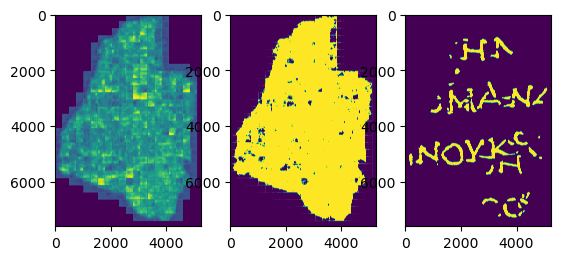

	 epoch:3, avg train loss:0.6380, avg valid loss:0.6989, score:0.1610(th=0.35) ::: time:37.72s
	 Epoch 3 - Save Best Score: 0.1610. Model is saved.
	 === epoch: 4: training ===
	 Epoch: [4][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.5896(0.5896) 
	 Epoch: [4][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5734(0.6112) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6031(0.6031) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5257(0.6735) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807337487286492
th: 0.15, fbeta: 0.13807337487286492
th: 0.2, fbeta: 0.13807543798383318
th: 0.25, fbeta: 0.13847946485054002
th: 0.3, fbeta: 0.15169322306868593
th: 0.35, fbeta: 0.1600381009586709
th: 0.4, fbeta: 0.1598805072077802
th: 0.45, fbeta: 0.1561546880601043
th: 0.5, fbeta: 0.14914837490503052
th: 0.55, fbeta: 0.1447324256184737
th: 0.6, fbeta: 0.13851497116239425
th: 0.65, fbeta: 0.12993315100061684
th: 0.7, fbeta: 0.1274613261193853
th:

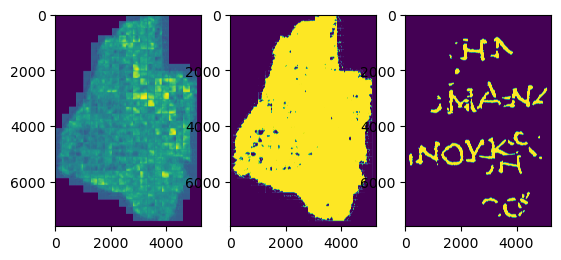

	 epoch:4, avg train loss:0.6112, avg valid loss:0.6735, score:0.1600(th=0.35) ::: time:50.51s
	 === epoch: 5: training ===
	 Epoch: [5][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.5847(0.5847) 
	 Epoch: [5][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5938(0.5629) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.7878(0.7878) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4501(0.9550) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807365379801628
th: 0.15, fbeta: 0.13956908417190372
th: 0.2, fbeta: 0.1534692966049315
th: 0.25, fbeta: 0.15842935293387372
th: 0.3, fbeta: 0.1604423063827318
th: 0.35, fbeta: 0.15997999767785093
th: 0.4, fbeta: 0.1588358074987884
th: 0.45, fbeta: 0.15582159168962134
th: 0.5, fbeta: 0.15366248421539166
th: 0.55, fbeta: 0.15244714270753612
th: 0.6, fbeta: 0.15136626371835105
th: 0.65, fbeta: 0.15220162688519728
th: 0.7, fbeta: 0.15108642192835756
th: 0.75, fbeta: 0.15006762155914088
th: 0.8, fbeta: 0

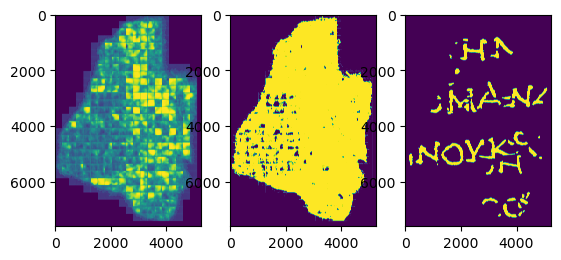

	 epoch:5, avg train loss:0.5629, avg valid loss:0.9550, score:0.1604(th=0.3) ::: time:62.92s
	 === epoch: 6: training ===
	 Epoch: [6][0/31] Elapsed 0m 0s (remain 0m 19s) Loss: 0.6592(0.6592) 
	 Epoch: [6][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5399(0.5497) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4602(0.4602) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4546(0.5696) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807337487286492
th: 0.15, fbeta: 0.1378865416816234
th: 0.2, fbeta: 0.1495823403047461
th: 0.25, fbeta: 0.1533520139432372
th: 0.3, fbeta: 0.1562196807699274
th: 0.35, fbeta: 0.15326198666542096
th: 0.4, fbeta: 0.14586044257857328
th: 0.45, fbeta: 0.13836920658050567
th: 0.5, fbeta: 0.12914331903393683
th: 0.55, fbeta: 0.1193043686051474
th: 0.6, fbeta: 0.10931008957751207
th: 0.65, fbeta: 0.1011893903371302
th: 0.7, fbeta: 0.09713210798925222
th: 0.75, fbeta: 0.08636036009679934
th: 0.8, fbeta: 0.067

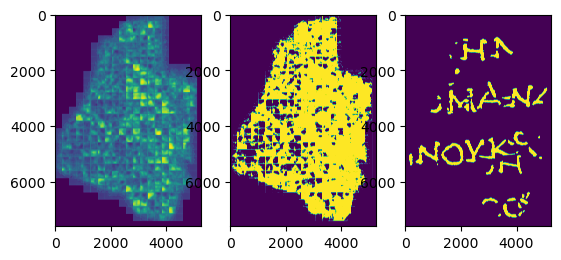

	 epoch:6, avg train loss:0.5497, avg valid loss:0.5696, score:0.1562(th=0.3) ::: time:75.64s
	 === epoch: 7: training ===
	 Epoch: [7][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.4761(0.4761) 
	 Epoch: [7][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4484(0.5067) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4512(0.4512) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4272(0.5909) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807338449095485
th: 0.15, fbeta: 0.13810801830227032
th: 0.2, fbeta: 0.14548356135872798
th: 0.25, fbeta: 0.15638714831995143
th: 0.3, fbeta: 0.15414474547533022
th: 0.35, fbeta: 0.15226553747903687
th: 0.4, fbeta: 0.14679345080029435
th: 0.45, fbeta: 0.13924674852558624
th: 0.5, fbeta: 0.13286707634991599
th: 0.55, fbeta: 0.12934818973628592
th: 0.6, fbeta: 0.12687081067421832
th: 0.65, fbeta: 0.11947686851490179
th: 0.7, fbeta: 0.10608269833152956
th: 0.75, fbeta: 0.08798220473565116
th: 0.8, fbeta:

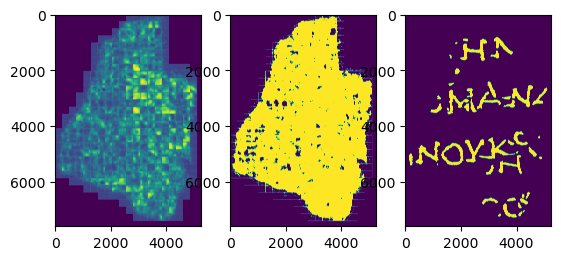

	 epoch:7, avg train loss:0.5067, avg valid loss:0.5909, score:0.1564(th=0.25) ::: time:88.15s
	 === epoch: 8: training ===
	 Epoch: [8][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.5356(0.5356) 
	 Epoch: [8][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.4250(0.4664) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.3943(0.3943) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4367(0.5315) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807737152683952
th: 0.15, fbeta: 0.1369221873254335
th: 0.2, fbeta: 0.13145669945548172
th: 0.25, fbeta: 0.14697577280051133
th: 0.3, fbeta: 0.15327742258922952
th: 0.35, fbeta: 0.1524577127671299
th: 0.4, fbeta: 0.14736816934718347
th: 0.45, fbeta: 0.13558789386695438
th: 0.5, fbeta: 0.12989844535730144
th: 0.55, fbeta: 0.12556422889908267
th: 0.6, fbeta: 0.11592421076111045
th: 0.65, fbeta: 0.10321270731788532
th: 0.7, fbeta: 0.09075180086901669
th: 0.75, fbeta: 0.07284022976983652
th: 0.8, fbeta: 

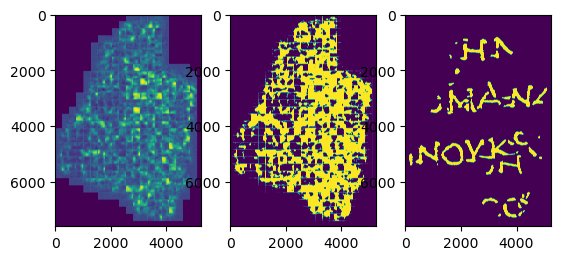

	 epoch:8, avg train loss:0.4664, avg valid loss:0.5315, score:0.1533(th=0.3) ::: time:100.78s
	 === epoch: 9: training ===
	 Epoch: [9][0/31] Elapsed 0m 0s (remain 0m 18s) Loss: 0.5141(0.5141) 
	 Epoch: [9][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.4416(0.4537) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 5s) Loss: 0.4300(0.4300) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4739(0.5795) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13808996706886117
th: 0.15, fbeta: 0.1378705075821686
th: 0.2, fbeta: 0.13527306991726928
th: 0.25, fbeta: 0.14806145848709446
th: 0.3, fbeta: 0.15237121345866278
th: 0.35, fbeta: 0.15328767096072798
th: 0.4, fbeta: 0.15116652425027263
th: 0.45, fbeta: 0.14521076673992958
th: 0.5, fbeta: 0.13774393152114198
th: 0.55, fbeta: 0.1280531449520346
th: 0.6, fbeta: 0.12050067733539822
th: 0.65, fbeta: 0.11329016469936584
th: 0.7, fbeta: 0.10530782181877656
th: 0.75, fbeta: 0.0933137157420934
th: 0.8, fbeta: 0

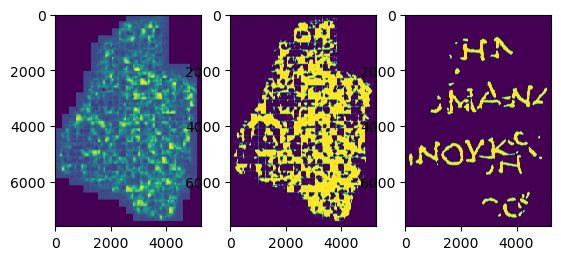

	 epoch:9, avg train loss:0.4537, avg valid loss:0.5795, score:0.1533(th=0.35) ::: time:113.46s
	 === epoch: 10: training ===
	 Epoch: [10][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.3807(0.3807) 
	 Epoch: [10][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3960(0.4454) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 3s) Loss: 0.4784(0.4784) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5145(0.6257) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13809404515064447
th: 0.15, fbeta: 0.13771346033409396
th: 0.2, fbeta: 0.1349732742527909
th: 0.25, fbeta: 0.14802126400682444
th: 0.3, fbeta: 0.15174414335523972
th: 0.35, fbeta: 0.1519189107260819
th: 0.4, fbeta: 0.14982381453237784
th: 0.45, fbeta: 0.14435700929571946
th: 0.5, fbeta: 0.13980411443163562
th: 0.55, fbeta: 0.13448975177660163
th: 0.6, fbeta: 0.12927446906936327
th: 0.65, fbeta: 0.12387737679392537
th: 0.7, fbeta: 0.1191672759107672
th: 0.75, fbeta: 0.1109319689820357
th: 0.8, fbeta

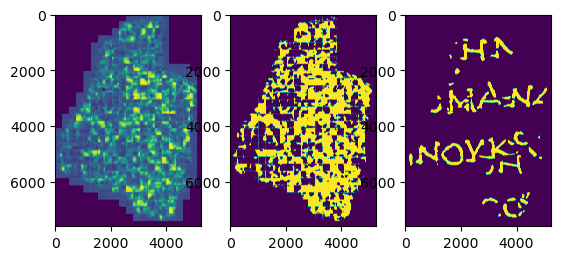

	 epoch:10, avg train loss:0.4454, avg valid loss:0.6257, score:0.1519(th=0.35) ::: time:126.01s
	 === epoch: 11: training ===
	 Epoch: [11][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.4230(0.4230) 
	 Epoch: [11][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3688(0.4336) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4223(0.4223) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4710(0.5836) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1380922294665891
th: 0.15, fbeta: 0.13775544035567316
th: 0.2, fbeta: 0.1349839738738863
th: 0.25, fbeta: 0.14988708349375263
th: 0.3, fbeta: 0.1532691288550957
th: 0.35, fbeta: 0.15425897212855783
th: 0.4, fbeta: 0.1516867403365818
th: 0.45, fbeta: 0.14478315614840873
th: 0.5, fbeta: 0.13871868384714675
th: 0.55, fbeta: 0.1307657798070455
th: 0.6, fbeta: 0.12512273497428583
th: 0.65, fbeta: 0.11908237824322321
th: 0.7, fbeta: 0.10793957091063322
th: 0.75, fbeta: 0.09470481470865531
th: 0.8, fbeta

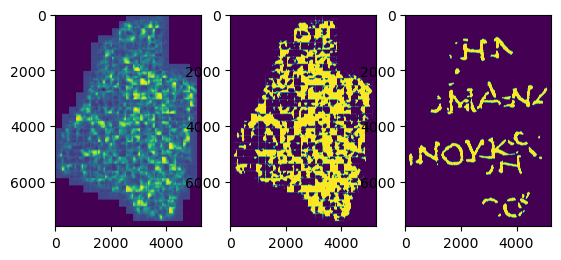

	 epoch:11, avg train loss:0.4336, avg valid loss:0.5836, score:0.1543(th=0.35) ::: time:138.45s
	 === epoch: 12: training ===
	 Epoch: [12][0/31] Elapsed 0m 0s (remain 0m 15s) Loss: 0.4658(0.4658) 
	 Epoch: [12][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5622(0.4334) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4646(0.4646) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4994(0.5989) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13808347764769718
th: 0.15, fbeta: 0.13791767678479
th: 0.2, fbeta: 0.13606665184704586
th: 0.25, fbeta: 0.14901764069345252
th: 0.3, fbeta: 0.15299508585446542
th: 0.35, fbeta: 0.15234993472396274
th: 0.4, fbeta: 0.15025013819202393
th: 0.45, fbeta: 0.14290745979182795
th: 0.5, fbeta: 0.1370068453879207
th: 0.55, fbeta: 0.1320907369685453
th: 0.6, fbeta: 0.12406435000164574
th: 0.65, fbeta: 0.11711315110648535
th: 0.7, fbeta: 0.11193833972168467
th: 0.75, fbeta: 0.10297142625897863
th: 0.8, fbeta

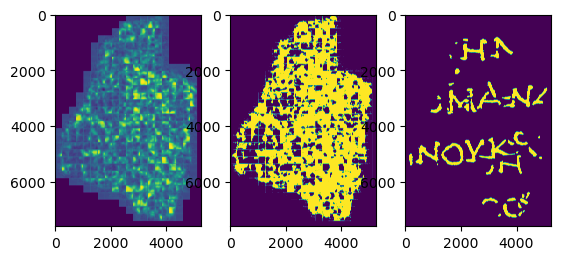

	 epoch:12, avg train loss:0.4334, avg valid loss:0.5989, score:0.1530(th=0.3) ::: time:150.77s
	 === epoch: 13: training ===
	 Epoch: [13][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.4323(0.4323) 
	 Epoch: [13][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.4913(0.4259) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4518(0.4518) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5194(0.6345) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13808787230578543
th: 0.15, fbeta: 0.13782128385380563
th: 0.2, fbeta: 0.13542980784133588
th: 0.25, fbeta: 0.15136823652249506
th: 0.3, fbeta: 0.15454566845967077
th: 0.35, fbeta: 0.15392543378758738
th: 0.4, fbeta: 0.1523772905127268
th: 0.45, fbeta: 0.14769812129786775
th: 0.5, fbeta: 0.14159696944472452
th: 0.55, fbeta: 0.13599910205740656
th: 0.6, fbeta: 0.1299397189994391
th: 0.65, fbeta: 0.1247213201873034
th: 0.7, fbeta: 0.11888178023450947
th: 0.75, fbeta: 0.11103138016052823
th: 0.8, fbet

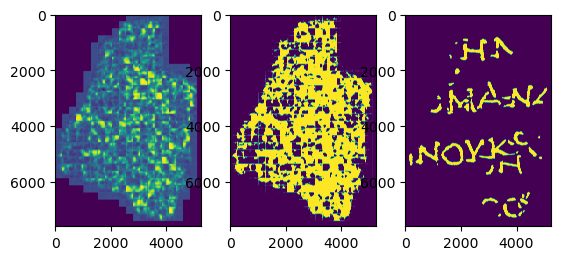

	 epoch:13, avg train loss:0.4259, avg valid loss:0.6345, score:0.1545(th=0.3) ::: time:163.28s
	 === epoch: 14: training ===
	 Epoch: [14][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.3572(0.3572) 
	 Epoch: [14][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4019(0.4186) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.3820(0.3820) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5293(0.5964) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13807385949605502
th: 0.15, fbeta: 0.13803654706739973
th: 0.2, fbeta: 0.1382562200790322
th: 0.25, fbeta: 0.15335049145368276
th: 0.3, fbeta: 0.15285138805307175
th: 0.35, fbeta: 0.15041734272424648
th: 0.4, fbeta: 0.1490322883554813
th: 0.45, fbeta: 0.14468740153623297
th: 0.5, fbeta: 0.14014347532612162
th: 0.55, fbeta: 0.13491815660657397
th: 0.6, fbeta: 0.12839815364654622
th: 0.65, fbeta: 0.12146029363504122
th: 0.7, fbeta: 0.1174163865068382
th: 0.75, fbeta: 0.11430925408693744
th: 0.8, fbet

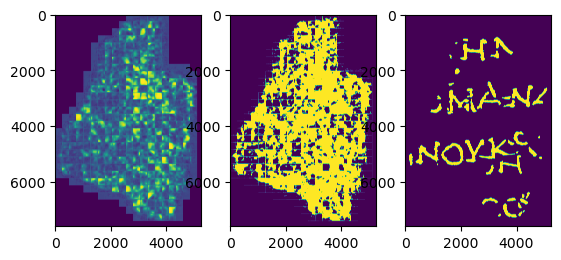

	 epoch:14, avg train loss:0.4186, avg valid loss:0.5964, score:0.1534(th=0.25) ::: time:175.72s
	 === epoch: 15: training ===
	 Epoch: [15][0/31] Elapsed 0m 0s (remain 0m 18s) Loss: 0.3806(0.3806) 
	 Epoch: [15][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5389(0.3981) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.3964(0.3964) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5256(0.6181) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.13791611497372785
th: 0.15, fbeta: 0.13752421150762983
th: 0.2, fbeta: 0.13445614635393036
th: 0.25, fbeta: 0.1529119268941172
th: 0.3, fbeta: 0.15642697172978698
th: 0.35, fbeta: 0.15195178976528423
th: 0.4, fbeta: 0.14885572433553507
th: 0.45, fbeta: 0.14735644834429643
th: 0.5, fbeta: 0.14511803954683078
th: 0.55, fbeta: 0.13997800713025918
th: 0.6, fbeta: 0.13532791252197032
th: 0.65, fbeta: 0.13047055496098914
th: 0.7, fbeta: 0.1258877717865007
th: 0.75, fbeta: 0.11841099157469819
th: 0.8, fb

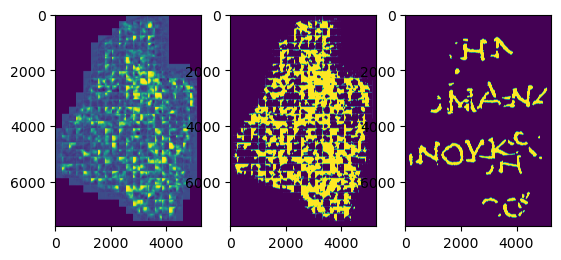

	 epoch:15, avg train loss:0.3981, avg valid loss:0.6181, score:0.1564(th=0.3) ::: time:188.28s
	 === epoch: 16: training ===
	 Epoch: [16][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.3760(0.3760) 
	 Epoch: [16][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3577(0.3912) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5310(0.5310) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8484(0.9259) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1379290199822019
th: 0.15, fbeta: 0.13904578631346803
th: 0.2, fbeta: 0.15326402188842195
th: 0.25, fbeta: 0.15347212409738287
th: 0.3, fbeta: 0.1526359592227188
th: 0.35, fbeta: 0.1515629147068605
th: 0.4, fbeta: 0.15022292923795125
th: 0.45, fbeta: 0.14907644464110045
th: 0.5, fbeta: 0.14783383869226818
th: 0.55, fbeta: 0.14541778613599757
th: 0.6, fbeta: 0.14207238802280403
th: 0.65, fbeta: 0.13819364612077034
th: 0.7, fbeta: 0.13405725575907804
th: 0.75, fbeta: 0.13067201800914555
th: 0.8, fbet

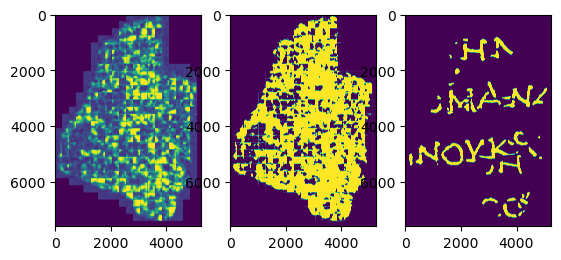

	 epoch:16, avg train loss:0.3912, avg valid loss:0.9259, score:0.1535(th=0.25) ::: time:200.56s
	 === epoch: 17: training ===
	 Epoch: [17][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.3868(0.3868) 
	 Epoch: [17][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3641(0.3797) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.2889(0.2889) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4374(0.5385) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1377858159409081
th: 0.15, fbeta: 0.1466937457837544
th: 0.2, fbeta: 0.15761324530685508
th: 0.25, fbeta: 0.16081949100686674
th: 0.3, fbeta: 0.154944145491357
th: 0.35, fbeta: 0.14550592327163178
th: 0.4, fbeta: 0.1350897923295455
th: 0.45, fbeta: 0.12642636914242944
th: 0.5, fbeta: 0.11919848117802871
th: 0.55, fbeta: 0.11075858576891798
th: 0.6, fbeta: 0.10246714932023168
th: 0.65, fbeta: 0.09457434252537608
th: 0.7, fbeta: 0.08694306196011216
th: 0.75, fbeta: 0.0788524314320013
th: 0.8, fbeta:

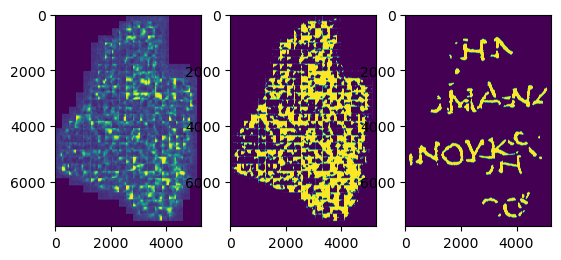

	 epoch:17, avg train loss:0.3797, avg valid loss:0.5385, score:0.1608(th=0.25) ::: time:212.91s
	 === epoch: 18: training ===
	 Epoch: [18][0/31] Elapsed 0m 0s (remain 0m 18s) Loss: 0.3213(0.3213) 
	 Epoch: [18][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4047(0.3725) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.1967(0.1967) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3238(0.4326) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.15258138497003598
th: 0.15, fbeta: 0.1507416137693796
th: 0.2, fbeta: 0.15630486898387613
th: 0.25, fbeta: 0.15941889562921
th: 0.3, fbeta: 0.1490563072056408
th: 0.35, fbeta: 0.13595197447977736
th: 0.4, fbeta: 0.12589211062622635
th: 0.45, fbeta: 0.11210527637841396
th: 0.5, fbeta: 0.09591735303217312
th: 0.55, fbeta: 0.08187929280682398
th: 0.6, fbeta: 0.06753440344433778
th: 0.65, fbeta: 0.05393416421758802
th: 0.7, fbeta: 0.042528329075617204
th: 0.75, fbeta: 0.03204331585945032
th: 0.8, fbet

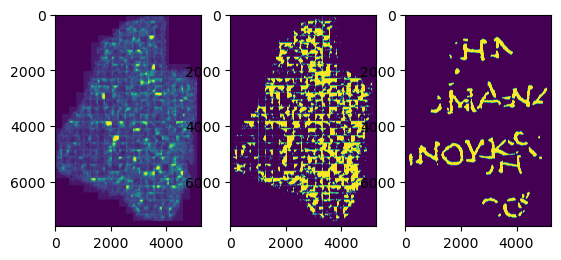

	 epoch:18, avg train loss:0.3725, avg valid loss:0.4326, score:0.1594(th=0.25) ::: time:225.41s
	 === epoch: 19: training ===
	 Epoch: [19][0/31] Elapsed 0m 0s (remain 0m 15s) Loss: 0.2843(0.2843) 
	 Epoch: [19][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4436(0.5018) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.2968(0.2968) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3792(0.4630) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1442775042790161
th: 0.15, fbeta: 0.15484183857956485
th: 0.2, fbeta: 0.15789098144004882
th: 0.25, fbeta: 0.15718811828339654
th: 0.3, fbeta: 0.15301412173182294
th: 0.35, fbeta: 0.15697862428927814
th: 0.4, fbeta: 0.15899171991020494
th: 0.45, fbeta: 0.14813444805834877
th: 0.5, fbeta: 0.1285295194302526
th: 0.55, fbeta: 0.11050905258079628
th: 0.6, fbeta: 0.09281577156206976
th: 0.65, fbeta: 0.07817508840098451
th: 0.7, fbeta: 0.06388936080603155
th: 0.75, fbeta: 0.05230725975012213
th: 0.8, fb

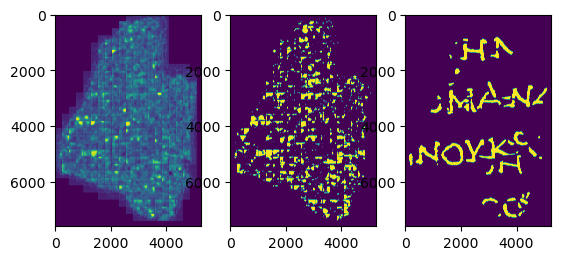

	 epoch:19, avg train loss:0.5018, avg valid loss:0.4630, score:0.1590(th=0.4) ::: time:237.75s
	 === epoch: 20: training ===
	 Epoch: [20][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7727(0.7727) 
	 Epoch: [20][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4785(0.5037) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6363(0.6363) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6298(0.8361) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1380781600380927
th: 0.15, fbeta: 0.15028913085250792
th: 0.2, fbeta: 0.15729691969996148
th: 0.25, fbeta: 0.16263622499380959
th: 0.3, fbeta: 0.1573842510130744
th: 0.35, fbeta: 0.14861481217554207
th: 0.4, fbeta: 0.14417839915205424
th: 0.45, fbeta: 0.1416193774136167
th: 0.5, fbeta: 0.14041535409514305
th: 0.55, fbeta: 0.13834920777108595
th: 0.6, fbeta: 0.13621196031135843
th: 0.65, fbeta: 0.13324805379156912
th: 0.7, fbeta: 0.13036202118000906
th: 0.75, fbeta: 0.1273367458288752
th: 0.8, fbeta

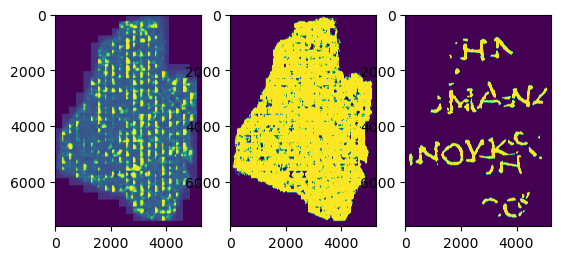

	 epoch:20, avg train loss:0.5037, avg valid loss:0.8361, score:0.1626(th=0.25) ::: time:250.10s
	 Epoch 20 - Save Best Score: 0.1626. Model is saved.
	 === epoch: 21: training ===
	 Epoch: [21][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.4608(0.4608) 
	 Epoch: [21][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4196(0.4263) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6570(0.6570) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4234(0.7088) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1575555170951292
th: 0.15, fbeta: 0.15772818242238032
th: 0.2, fbeta: 0.1539035454482051
th: 0.25, fbeta: 0.1526467863524667
th: 0.3, fbeta: 0.14994076841964005
th: 0.35, fbeta: 0.14591357265666408
th: 0.4, fbeta: 0.14337495786628643
th: 0.45, fbeta: 0.14300619762868758
th: 0.5, fbeta: 0.1429104875038495
th: 0.55, fbeta: 0.14091787964218316
th: 0.6, fbeta: 0.13829271550401626
th: 0.65, fbeta: 0.13471192471856494
th: 0.7, fbeta: 0.12975426992967

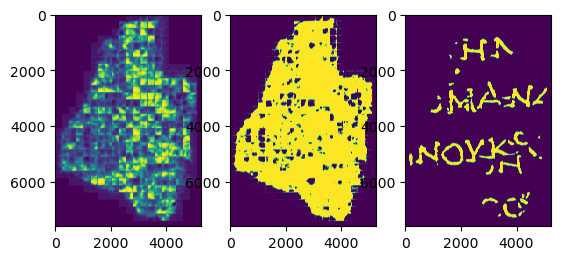

	 epoch:21, avg train loss:0.4263, avg valid loss:0.7088, score:0.1577(th=0.15) ::: time:262.62s
	 === epoch: 22: training ===
	 Epoch: [22][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.3727(0.3727) 
	 Epoch: [22][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3902(0.3760) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.7957(0.7957) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4305(0.8878) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.15748177195112967
th: 0.15, fbeta: 0.15848619129958735
th: 0.2, fbeta: 0.15367099405999549
th: 0.25, fbeta: 0.15112476568103456
th: 0.3, fbeta: 0.14961347068314235
th: 0.35, fbeta: 0.14636403854722146
th: 0.4, fbeta: 0.14312574597508315
th: 0.45, fbeta: 0.1397978277643615
th: 0.5, fbeta: 0.13680192516008985
th: 0.55, fbeta: 0.13620723295994414
th: 0.6, fbeta: 0.1350427960043119
th: 0.65, fbeta: 0.13272585958679578
th: 0.7, fbeta: 0.12866087595597567
th: 0.75, fbeta: 0.12392508606665825
th: 0.8, fb

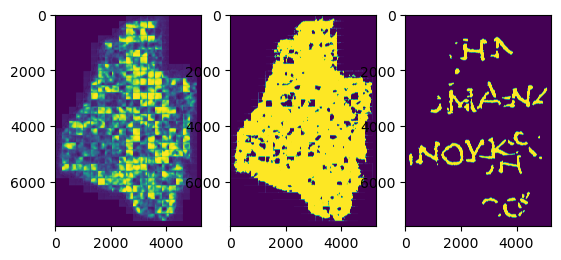

	 epoch:22, avg train loss:0.3760, avg valid loss:0.8878, score:0.1585(th=0.15) ::: time:275.32s
	 === epoch: 23: training ===
	 Epoch: [23][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.3338(0.3338) 
	 Epoch: [23][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2714(0.3427) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.3237(0.3237) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3719(0.4799) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.15498714212545983
th: 0.15, fbeta: 0.15663605715461393
th: 0.2, fbeta: 0.15259896993751348
th: 0.25, fbeta: 0.15157085173818002
th: 0.3, fbeta: 0.15061938014037282
th: 0.35, fbeta: 0.1511991813056563
th: 0.4, fbeta: 0.1494291308435933
th: 0.45, fbeta: 0.1467854677259554
th: 0.5, fbeta: 0.1444709782933723
th: 0.55, fbeta: 0.14132890491147754
th: 0.6, fbeta: 0.137861575036494
th: 0.65, fbeta: 0.13315392634903764
th: 0.7, fbeta: 0.12462586985075887
th: 0.75, fbeta: 0.11242340659743234
th: 0.8, fbeta:

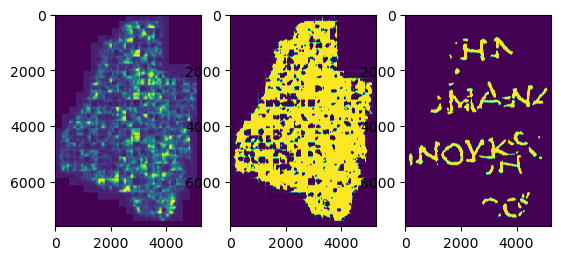

	 epoch:23, avg train loss:0.3427, avg valid loss:0.4799, score:0.1566(th=0.15) ::: time:288.08s
	 === epoch: 24: training ===
	 Epoch: [24][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.2502(0.2502) 
	 Epoch: [24][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3408(0.3056) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.3909(0.3909) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3382(0.4596) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.15746197288305536
th: 0.15, fbeta: 0.15638846174770185
th: 0.2, fbeta: 0.15311994547406993
th: 0.25, fbeta: 0.1502168128735804
th: 0.3, fbeta: 0.14631006284456066
th: 0.35, fbeta: 0.13993756524742612
th: 0.4, fbeta: 0.1335252872652515
th: 0.45, fbeta: 0.12806517516320445
th: 0.5, fbeta: 0.1218653342747034
th: 0.55, fbeta: 0.11578658817910181
th: 0.6, fbeta: 0.11059961290077795
th: 0.65, fbeta: 0.10353637875330853
th: 0.7, fbeta: 0.09718471831260415
th: 0.75, fbeta: 0.08910466653936729
th: 0.8, fbe

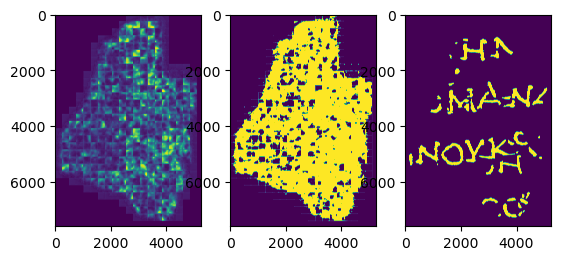

	 epoch:24, avg train loss:0.3056, avg valid loss:0.4596, score:0.1575(th=0.1) ::: time:301.01s
	 === epoch: 25: training ===
	 Epoch: [25][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.2721(0.2721) 
	 Epoch: [25][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2213(0.2980) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.3601(0.3601) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3791(0.4887) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1498017087381606
th: 0.15, fbeta: 0.15806231269163715
th: 0.2, fbeta: 0.1530518349818282
th: 0.25, fbeta: 0.14722418227376244
th: 0.3, fbeta: 0.1430633861068691
th: 0.35, fbeta: 0.14001289152079044
th: 0.4, fbeta: 0.1374984091307331
th: 0.45, fbeta: 0.13225756999541827
th: 0.5, fbeta: 0.12749689699353914
th: 0.55, fbeta: 0.1226259302886861
th: 0.6, fbeta: 0.11999634317434202
th: 0.65, fbeta: 0.1176934002859964
th: 0.7, fbeta: 0.11162580558358444
th: 0.75, fbeta: 0.10364498276239725
th: 0.8, fbeta: 

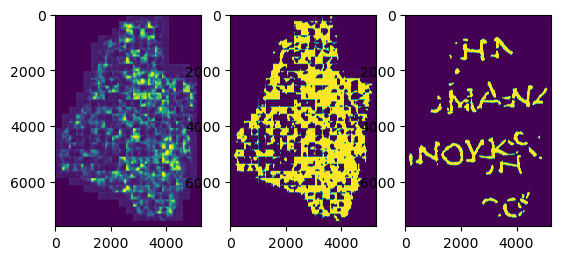

	 epoch:25, avg train loss:0.2980, avg valid loss:0.4887, score:0.1581(th=0.15) ::: time:313.74s
	 === epoch: 26: training ===
	 Epoch: [26][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.2409(0.2409) 
	 Epoch: [26][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2462(0.2709) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.2062(0.2062) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3318(0.4126) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1508888563786851
th: 0.15, fbeta: 0.14483463689974158
th: 0.2, fbeta: 0.1374986505285606
th: 0.25, fbeta: 0.1305096315186025
th: 0.3, fbeta: 0.12412774962772989
th: 0.35, fbeta: 0.11551778007527401
th: 0.4, fbeta: 0.10506236108901545
th: 0.45, fbeta: 0.09760884301036982
th: 0.5, fbeta: 0.08865974602942013
th: 0.55, fbeta: 0.07512198372450195
th: 0.6, fbeta: 0.061025276288315194
th: 0.65, fbeta: 0.049152994250209525
th: 0.7, fbeta: 0.03336903371864462
th: 0.75, fbeta: 0.019774211087592822
th: 0.8, 

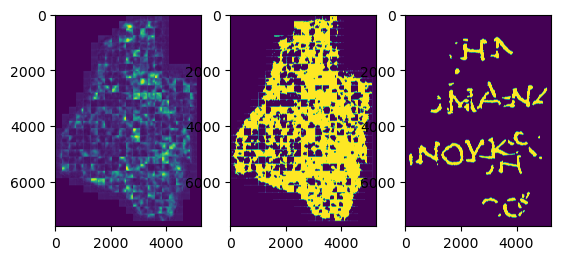

	 epoch:26, avg train loss:0.2709, avg valid loss:0.4126, score:0.1509(th=0.1) ::: time:326.27s
	 === epoch: 27: training ===
	 Epoch: [27][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.2171(0.2171) 
	 Epoch: [27][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3098(0.2379) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.2905(0.2905) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3763(0.4693) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.14976611788866764
th: 0.15, fbeta: 0.15131495159597577
th: 0.2, fbeta: 0.14650732210886186
th: 0.25, fbeta: 0.14326815153918063
th: 0.3, fbeta: 0.14084232409500627
th: 0.35, fbeta: 0.13886017344786303
th: 0.4, fbeta: 0.13578773640610275
th: 0.45, fbeta: 0.12987564248751546
th: 0.5, fbeta: 0.12169512541514664
th: 0.55, fbeta: 0.11591312740095565
th: 0.6, fbeta: 0.11025588733859791
th: 0.65, fbeta: 0.10431585430383958
th: 0.7, fbeta: 0.09491405167228756
th: 0.75, fbeta: 0.0829920220676925
th: 0.8, fb

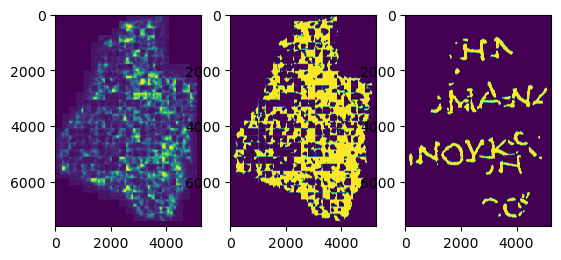

	 epoch:27, avg train loss:0.2379, avg valid loss:0.4693, score:0.1513(th=0.15) ::: time:338.95s
	 === epoch: 28: training ===
	 Epoch: [28][0/31] Elapsed 0m 0s (remain 0m 16s) Loss: 0.2413(0.2413) 
	 Epoch: [28][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2644(0.2374) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.2264(0.2264) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3577(0.4424) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.15110992186981415
th: 0.15, fbeta: 0.1518285406484947
th: 0.2, fbeta: 0.14575090486304168
th: 0.25, fbeta: 0.13796422108603223
th: 0.3, fbeta: 0.12950008208198605
th: 0.35, fbeta: 0.12426138633348648
th: 0.4, fbeta: 0.11908835295222912
th: 0.45, fbeta: 0.11419333306363871
th: 0.5, fbeta: 0.10996452752831884
th: 0.55, fbeta: 0.1037866354913836
th: 0.6, fbeta: 0.09679998744683857
th: 0.65, fbeta: 0.0908343028286093
th: 0.7, fbeta: 0.08343400955120951
th: 0.75, fbeta: 0.07105647982072998
th: 0.8, fbe

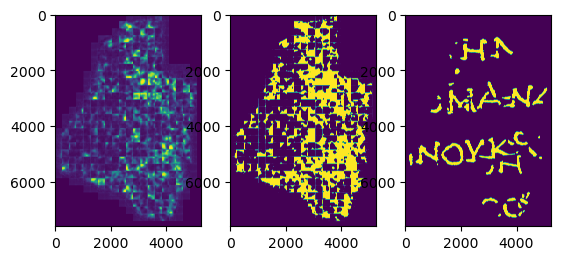

	 epoch:28, avg train loss:0.2374, avg valid loss:0.4424, score:0.1518(th=0.15) ::: time:351.64s
	 === epoch: 29: training ===
	 Epoch: [29][0/31] Elapsed 0m 0s (remain 0m 18s) Loss: 0.1749(0.1749) 
	 Epoch: [29][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2064(0.2157) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.3116(0.3116) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3935(0.4903) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.1513517555676145
th: 0.15, fbeta: 0.15220274247003998
th: 0.2, fbeta: 0.14781723687025325
th: 0.25, fbeta: 0.143621629124635
th: 0.3, fbeta: 0.13997146341661723
th: 0.35, fbeta: 0.13573329093584557
th: 0.4, fbeta: 0.13060540076496324
th: 0.45, fbeta: 0.12651129227329447
th: 0.5, fbeta: 0.12346600557288874
th: 0.55, fbeta: 0.11919584768770142
th: 0.6, fbeta: 0.11359650705045507
th: 0.65, fbeta: 0.10587116018575037
th: 0.7, fbeta: 0.09753460377214548
th: 0.75, fbeta: 0.09116493359559887
th: 0.8, fbe

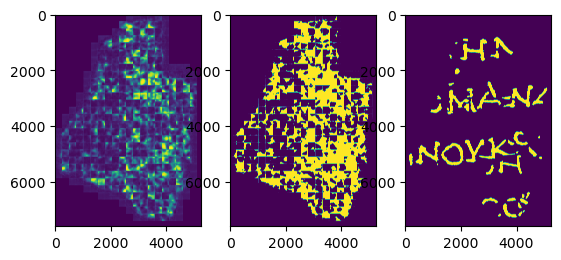

	 epoch:29, avg train loss:0.2157, avg valid loss:0.4903, score:0.1522(th=0.15) ::: time:364.27s
	 === epoch: 30: training ===
	 Epoch: [30][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.2075(0.2075) 
	 Epoch: [30][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1871(0.2219) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.2237(0.2237) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3652(0.4402) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)
th: 0.1, fbeta: 0.15172471018929348
th: 0.15, fbeta: 0.14997238645986555
th: 0.2, fbeta: 0.1441994701536229
th: 0.25, fbeta: 0.1390441869894771
th: 0.3, fbeta: 0.1346262624030613
th: 0.35, fbeta: 0.12862323691570554
th: 0.4, fbeta: 0.12415864687429372
th: 0.45, fbeta: 0.11893397885690885
th: 0.5, fbeta: 0.11080718070800402
th: 0.55, fbeta: 0.10212538052162777
th: 0.6, fbeta: 0.09557974870020797
th: 0.65, fbeta: 0.08838239472824476
th: 0.7, fbeta: 0.0775462392670452
th: 0.75, fbeta: 0.06501535437392036
th: 0.8, fbet

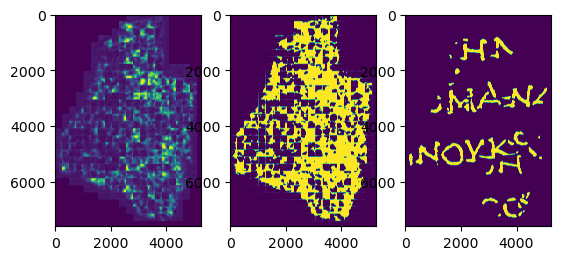

	 epoch:30, avg train loss:0.2219, avg valid loss:0.4402, score:0.1517(th=0.1) ::: time:376.60s


In [38]:
training_loop(CFG)
# if not CFG["DEBUG"]:
#     wandb.finish()